## Data load

In [61]:
import os
import random

# root = '/usr/local/MATLAB/R2024b/toolbox/lidar/lidardata/lcc/vlp16'
# root = '/data/tcar_no_intensity'
root = '/data/velodyne'
# root = '/data/Tcar_hs'

img_files = sorted(os.listdir(os.path.join(root, 'Image')))
pcd_files = sorted(os.listdir(os.path.join(root, 'PCD')))

idx = random.randint(0, len(img_files)-1)

## RoI and plane PCD Visualization

In [62]:
import open3d as o3d
import numpy as np
from utils.util import show_point_cloud
import random

idx = random.randint(0, len(img_files)-1)
img = Image.open(os.path.join(root, 'Image', img_files[idx]))
img.show()

pcd = o3d.io.read_point_cloud(os.path.join(root, 'PCD', pcd_files[idx]))
show_point_cloud(pcd, scailing=False, intensity=False)

points = np.asarray(pcd.points)
valid_mask = np.isfinite(points).all(axis=1)
points = points[valid_mask]

valid_mask = np.isfinite(points).all(axis=1)
points = points[valid_mask]

# Set region of interest (ROI)
mask = np.ones(points.shape[0])
# velodyne
mask = np.logical_and(mask, points[:, 0] < 6)
mask = np.logical_and(mask, points[:, 0] > 1)
mask = np.logical_and(mask, points[:, 1] < 3)
mask = np.logical_and(mask, points[:, 1] > -3)        
mask = np.logical_and(mask, points[:, 2] > -0.5)

roi_points = points[mask]
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(roi_points)

# Segment the plane using RANSAC
plane_model, inliers = pcd.segment_plane(distance_threshold=0.03, ransac_n=3, num_iterations=10000)
[a, b, c, d] = plane_model
plane_points = np.asarray(pcd.points)[inliers]

pcd.points = o3d.utility.Vector3dVector(plane_points)
plane_normal = np.array([a, b, c]) / np.linalg.norm([a, b, c])
plane_point = np.mean(plane_points, axis=0)

plane_pcd = o3d.geometry.PointCloud()
plane_pcd.points = o3d.utility.Vector3dVector(plane_points)

show_point_cloud(plane_pcd, scailing=False, intensity=False)

## Save the data

In [64]:
import open3d as o3d
import numpy as np
from utils.util import show_point_cloud
from tqdm import tqdm
from PIL import Image

# ---------- MAIN PIPELINE ----------
img_path = '../data/Image'
pcd_path = '../data/PCD'
whole_pcd_path = '../data/WholePCD'

# Read the point cloud file
os.makedirs(os.path.join(img_path), exist_ok=True)
os.makedirs(os.path.join(pcd_path), exist_ok=True)
os.makedirs(os.path.join(whole_pcd_path), exist_ok=True)

for i in tqdm(range(len(img_files))):
    # idx = random.randint(0, len(img_files)-1)
    idx = i
    pcd = o3d.io.read_point_cloud(os.path.join(root, 'PCD', pcd_files[idx]))
    # show_point_cloud(pcd, scailing=False, intensity=False)

    points = np.asarray(pcd.points)
    valid_mask = np.isfinite(points).all(axis=1)
    points = points[valid_mask]
    np.save(f"{whole_pcd_path}/{pcd_files[idx][:6]}.npy", points)

    # Set region of interest (ROI)
    mask = np.ones(points.shape[0])
    # velodyne
    mask = np.logical_and(mask, points[:, 0] < 6)
    mask = np.logical_and(mask, points[:, 0] > 1)
    mask = np.logical_and(mask, points[:, 1] < 3)
    mask = np.logical_and(mask, points[:, 1] > -3)        
    mask = np.logical_and(mask, points[:, 2] > -0.5)

    roi_points = points[mask]
    roi_pcd = o3d.geometry.PointCloud()
    roi_pcd.points = o3d.utility.Vector3dVector(roi_points)

    # Segment the plane using RANSAC
    plane_model, inliers = roi_pcd.segment_plane(distance_threshold=0.03, ransac_n=3, num_iterations=10000)
    [a, b, c, d] = plane_model
    plane_points = np.asarray(roi_pcd.points)[inliers]

    plane_pcd.points = o3d.utility.Vector3dVector(plane_points)
    plane_normal = np.array([a, b, c]) / np.linalg.norm([a, b, c])
    plane_center_point = np.mean(plane_points, axis=0)

    plane_pcd = o3d.geometry.PointCloud()
    plane_pcd.points = o3d.utility.Vector3dVector(plane_points)
    # show_point_cloud(plane_pcd, scailing=False, intensity=False)

    np.save(f"{pcd_path}/{pcd_files[idx][:6]}.npy", np.asarray(plane_pcd.points))
    img = Image.open(os.path.join(root, 'Image', img_files[idx])) 
    img.save(f'{img_path}/{img_files[idx][:6]}.png')

100%|██████████| 1465/1465 [01:50<00:00, 13.28it/s]


## Check the RoI data and save by handcraft

In [56]:
import open3d as o3d
import numpy as np
from utils.util import show_point_cloud
from tqdm import tqdm
from PIL import Image

# 1344 1397 630 359 136 164 720 925 224 286 1136 69 0 811 866 1463
idx = 27

# ---------- MAIN PIPELINE ----------
img_path = '../data/Image'
pcd_path = '../data/PCD'
whole_pcd_path = '../data/WholePCD'

# Read the point cloud file
os.makedirs(os.path.join(img_path), exist_ok=True)
os.makedirs(os.path.join(pcd_path), exist_ok=True)
os.makedirs(os.path.join(whole_pcd_path), exist_ok=True)

pcd = o3d.io.read_point_cloud(os.path.join(root, 'PCD', pcd_files[idx]))
show_point_cloud(pcd, scailing=False, intensity=False)

points = np.asarray(pcd.points)
valid_mask = np.isfinite(points).all(axis=1)
points = points[valid_mask]
np.save(f"{whole_pcd_path}/{pcd_files[idx][:6]}.npy", points)

# Set region of interest (ROI)
mask = np.ones(points.shape[0])
# velodyne
mask = np.logical_and(mask, points[:, 0] < 6)
mask = np.logical_and(mask, points[:, 0] > 1)
mask = np.logical_and(mask, points[:, 1] < 3)
mask = np.logical_and(mask, points[:, 1] > -3)        
mask = np.logical_and(mask, points[:, 2] > -0.6)

roi_points = points[mask]
roi_pcd = o3d.geometry.PointCloud()
roi_pcd.points = o3d.utility.Vector3dVector(roi_points)

# Segment the plane using RANSAC
plane_model, inliers = roi_pcd.segment_plane(distance_threshold=0.01, ransac_n=3, num_iterations=10000)
[a, b, c, d] = plane_model
plane_points = np.asarray(roi_pcd.points)[inliers]

plane_pcd = o3d.geometry.PointCloud()
plane_pcd.points = o3d.utility.Vector3dVector(plane_points)
plane_normal = np.array([a, b, c]) / np.linalg.norm([a, b, c])
plane_center_point = np.mean(plane_points, axis=0)

plane_pcd = o3d.geometry.PointCloud()
plane_pcd.points = o3d.utility.Vector3dVector(plane_points)
show_point_cloud(plane_pcd, scailing=False, intensity=False)

np.save(f"{pcd_path}/{pcd_files[idx][:6]}.npy", np.asarray(plane_pcd.points))
img = Image.open(os.path.join(root, 'Image', img_files[idx])) 
img.save(f'{img_path}/{img_files[idx][:6]}.png')

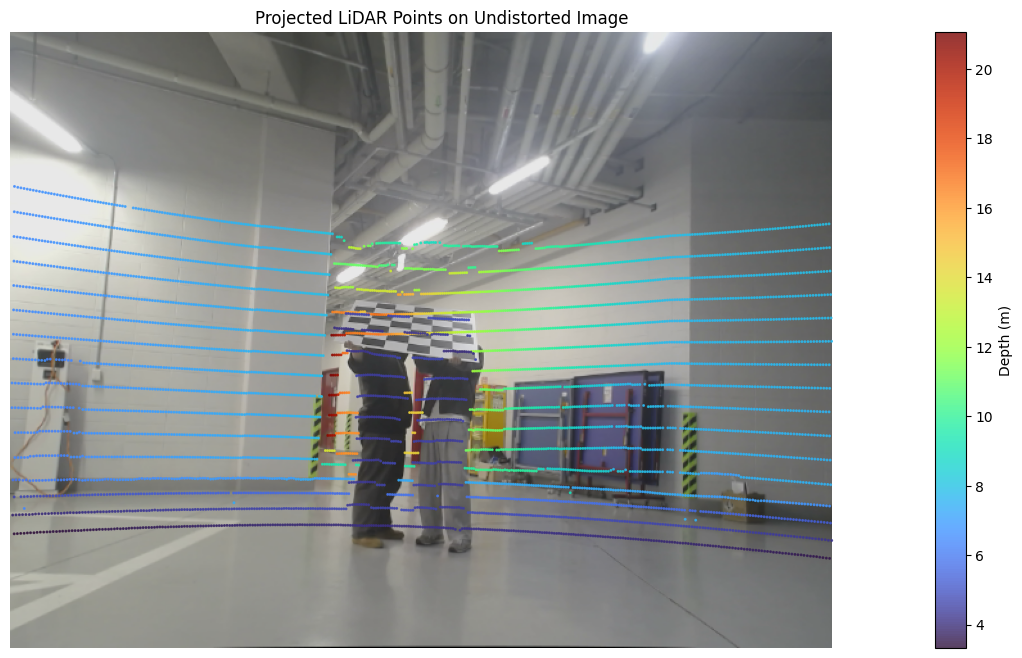

In [325]:
import os
import numpy as np
import open3d as o3d
from PIL import Image
import cv2
import random
import matplotlib.pyplot as plt

# ========================== Settings ==========================
ROI = False
root = '/data/velodyne'

# Camera intrinsic parameters
fx, fy, cx, cy = 478.54720499, 478.23953383, 331.89025576, 257.34755925
K = np.array([
    [fx, 0, cx],
    [0, fy, cy],
    [0,  0, 1]
], dtype=np.float32)

# Camera distortion coefficients
dist_coeffs = np.array([0.04776251, -0.17139481, 0.00194125, 0.00161106, 0.05056932], dtype=np.float32)

# Extrinsic (rotation and translation from ego to camera frame)
R = np.load(os.path.join('../results/28-04-2025-21-14-55', 'r.npy'))
T = np.load(os.path.join('../results/28-04-2025-21-14-55', 't.npy')).reshape(-1) / 1000  # converted from mm to m
# Create 4x4 homogeneous transformation matrix
RT = np.eye(4, dtype=np.float32)
RT[:3, :3] = R
RT[:3, 3] = T

# ========================== Data loading ==========================
# Load file lists
img_files = sorted(os.listdir(os.path.join(root, 'Image')))
pcd_files = sorted(os.listdir(os.path.join(root, 'PCD')))
idx = random.randint(0, len(img_files) - 1)

# Load point cloud
pcd = o3d.io.read_point_cloud(os.path.join(root, 'PCD', pcd_files[idx]))
points = np.asarray(pcd.points)

# Load and undistort image
img = cv2.imread(os.path.join(root, 'Image', img_files[idx]))
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

undistorted_img = cv2.undistort(rgb_img, cameraMatrix=K, distCoeffs=dist_coeffs)

height, width = undistorted_img.shape[:2]

# ========================== Transform points and project ==========================
if ROI:
    mask = np.ones(points.shape[0], dtype=bool)
    points = points[mask]

points_homo = np.hstack((points, np.ones((points.shape[0], 1)))).T

# Transform points from ego frame to camera frame
points_cam = RT @ points_homo

# Project camera frame points to image plane
points_img = K @ points_cam[:3, :]
points_img /= points_img[2, :]

u, v = points_img[0], points_img[1]
depths = points_cam[2, :]

# Filter points within image boundary and positive depth
mask = (u > 1) & (u < width) & (v > 1) & (v < height) & (depths > 0)
u, v, depths = u[mask], v[mask], depths[mask]

# ========================== Visualization ==========================
plt.figure(figsize=(16, 8))
plt.imshow(undistorted_img)
sc = plt.scatter(u, v, s=1.2, c=depths, cmap='turbo', alpha=0.8)
plt.colorbar(sc, label='Depth (m)')
plt.axis('off')
plt.title("Projected LiDAR Points on Undistorted Image")
plt.show()